This is based off an old notebook by Ben Pope. If we can recreate what he did using lightkurve alone, it will be a success!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
from astropy.stats import LombScargle
import astropy.units as u                          # We'll need this later.

from astropy.io import ascii
import glob, re

import lightkurve

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

In [43]:
lcs = lightkurve.search_lightcurvefile(8197761,cadence='long').download_all()
for j, lci in enumerate(lcs):
    lci = lci.get_lightcurve('PDCSAP_FLUX').remove_nans()
    lci = lci[lci.quality==0]
    lcs[j] = lci.normalize()

lcr = lcs[0]
for lci in lcs[1:]:
    lcr = lcr.append(lci)

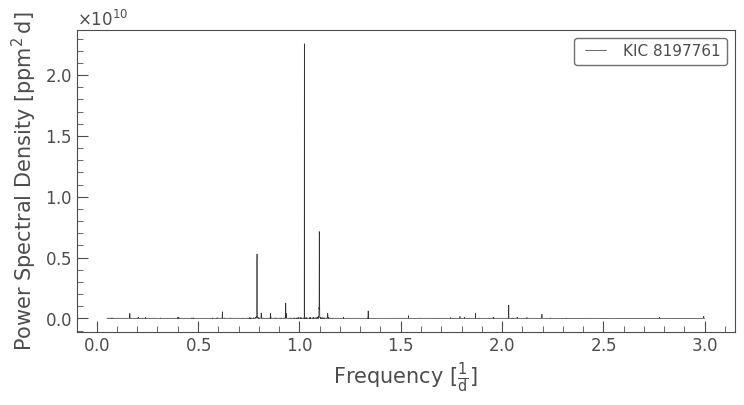

In [44]:
pg = lcr.to_periodogram(min_period = 8./24.*u.day, max_period=20.*u.day)
pg.plot()

In [45]:
y_fit = LombScargle(lcr.time, lcr.flux, lcr.flux_err).model(lcr.time, pg.frequency_at_max_power.value)

(120.53833690600732, 170.53833690600732)

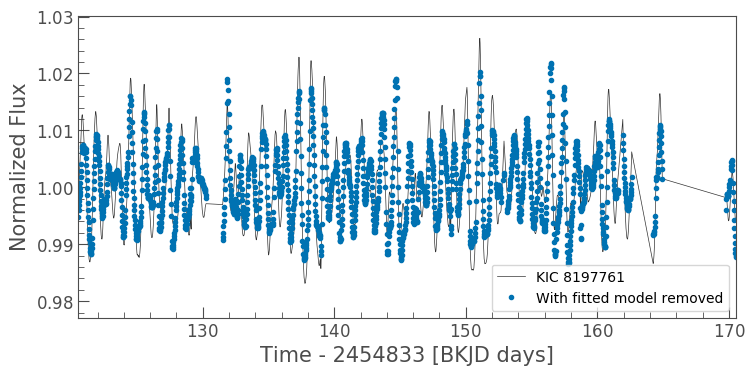

In [46]:
ax = lcr.plot()
ax.plot(lcr.time,lcr.flux-y_fit+1,'.', label='With fitted model removed')
ax.legend()
ax.set_xlim(lcr.time.min(),lcr.time.min()+50)

Take out the oscillation of highest power iteratively

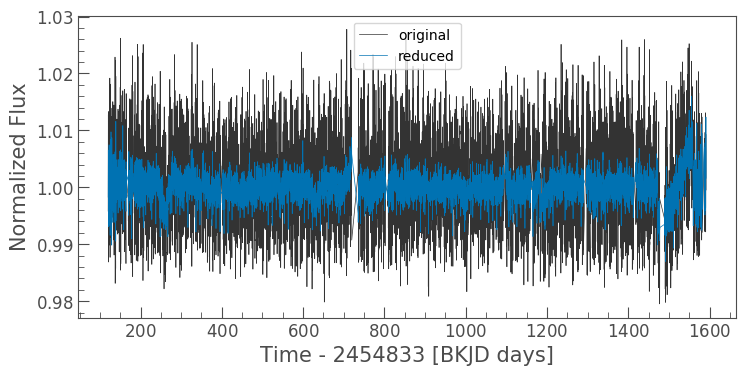

In [21]:
ff, pp = [], []
for j in range(60):
    pg = lc.to_periodogram(min_period=4./24.*u.day, max_period=30.*u.day)
    ff.append(pg.frequency_at_max_power.value)
    pp.append(pg.max_power.value)
    y_fit = LombScargle(lc.time, lc.flux, lc.flux_err).model(lc.time, pg.frequency_at_max_power.value)
    lc.flux = lc.flux- y_fit + 1.
ax = lcr.plot(label='original')
lc.plot(ax=ax, label='reduced')
ax.legend()
plt.show()

Check the flattening worked

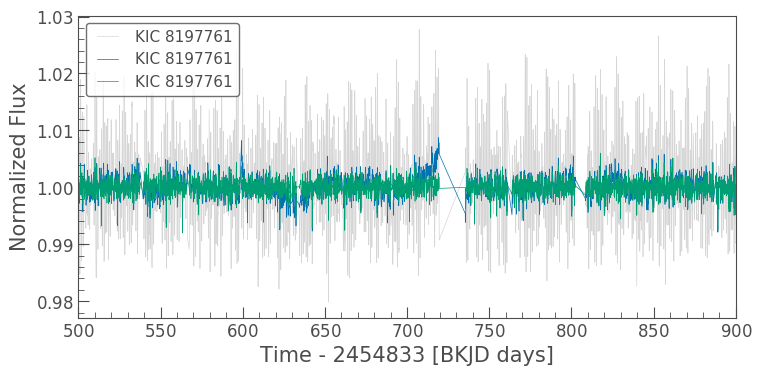

In [24]:
ax = lcr.plot(alpha=.2)
lc.plot(ax=ax)
lc.flatten().plot(ax=ax)
plt.xlim(500,900)
plt.show()

Fold the planet on the period, and bin

In [25]:
planet_period = 9.8686667
folded = lc.fold(planet_period, transit_midpoint = planet_period)
binned = folded.bin(binsize=25,method='median')

Text(0.5, 1.0, 'KIC 8197761: Period 9.869 d')

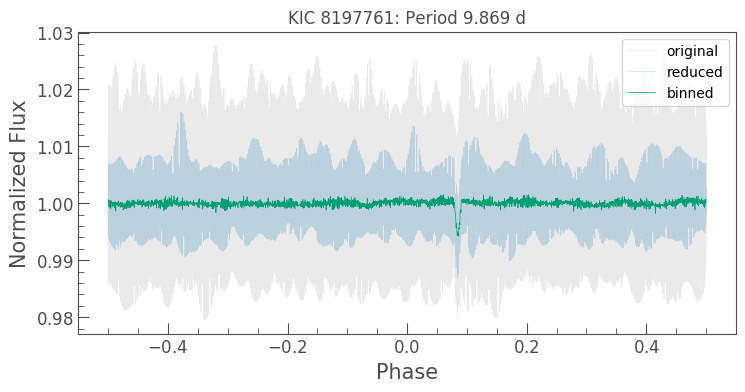

In [34]:
ax = lcr.fold(planet_period, transit_midpoint = planet_period).plot(alpha=.1, label='original')
folded.plot(alpha=.2, ax=ax, label='reduced')
binned.plot(ax=ax, label='binned')
ax.legend()
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))